In [1]:
from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from io import BytesIO
import requests
import gc
import random
import string
import cv2
import os
from pickle import dump, load
import json
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention, add
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.optimizers import Adam
from keras_applications.xception import Xception, preprocess_input
from keras_preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.utils import plot_model


In [2]:
# URL del archivo JSON de COCO
url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

# Descarga el archivo
response = requests.get(url)
response.raise_for_status()  # Asegúrate de que la solicitud fue exitosa

# Extrae el archivo JSON de la respuesta (asumiendo que el archivo JSON está en un ZIP)
from zipfile import ZipFile

with ZipFile(BytesIO(response.content)) as the_zip:
    with the_zip.open('annotations/instances_train2017.json') as file:
        coco_data = json.load(file)

# Carga los datos en el objeto COCO
coco = COCO()
coco.dataset = coco_data
coco.createIndex()

creating index...
index created!


In [3]:
#Identificar Categorias

cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

print("Número de categorías principales: ", len(maincategories))
print("Lista de categorías principales: ", maincategories)

Número de categorías principales:  12
Lista de categorías principales:  ['accessory', 'electronic', 'indoor', 'animal', 'vehicle', 'kitchen', 'appliance', 'person', 'food', 'sports', 'furniture', 'outdoor']


In [4]:
#Identificar Sub-Categorías

subcategories = [cat['name'] for cat in cats]

print("Number of sub categories: ", len(subcategories))
print("List of sub categories: ", subcategories)

Number of sub categories:  80
List of sub categories:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [5]:
#Sub-categorías con su correspondientes IDs

catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

print("Sub categorías con IDs :",subcategories_Ids)

Sub categorías con IDs : {'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 76, 'ce

In [6]:
#Total de imágenes para cada sub categoría

subcategories_imageIds = dict()

for i in range(0,len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    img = []
    for j in imgIds:
        img.append(j)
    subcategories_imageIds[subcategories[i]] = img

print("Sub-categorias con Image IDs :",len(subcategories_imageIds))

Sub-categorias con Image IDs : 80


In [7]:
length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
print("Imágenes totales en cada sub categoría: ", length_dict)

Imágenes totales en cada sub categoría:  {'person': 64115, 'bicycle': 3252, 'car': 12251, 'motorcycle': 3502, 'airplane': 2986, 'bus': 3952, 'train': 3588, 'truck': 6127, 'boat': 3025, 'traffic light': 4139, 'fire hydrant': 1711, 'stop sign': 1734, 'parking meter': 705, 'bench': 5570, 'bird': 3237, 'cat': 4114, 'dog': 4385, 'horse': 2941, 'sheep': 1529, 'cow': 1968, 'elephant': 2143, 'bear': 960, 'zebra': 1916, 'giraffe': 2546, 'backpack': 5528, 'umbrella': 3968, 'handbag': 6841, 'tie': 3810, 'suitcase': 2402, 'frisbee': 2184, 'skis': 3082, 'snowboard': 1654, 'sports ball': 4262, 'kite': 2261, 'baseball bat': 2506, 'baseball glove': 2629, 'skateboard': 3476, 'surfboard': 3486, 'tennis racket': 3394, 'bottle': 8501, 'wine glass': 2533, 'cup': 9189, 'fork': 3555, 'knife': 4326, 'spoon': 3529, 'bowl': 7111, 'banana': 2243, 'apple': 1586, 'sandwich': 2365, 'orange': 1699, 'broccoli': 1939, 'carrot': 1683, 'hot dog': 1222, 'pizza': 3166, 'donut': 1523, 'cake': 2925, 'chair': 12774, 'couch':

In [8]:
#Se seleccionan dos subcategorías Bicicleta y Avión para llevar a cabo 
#el proyecto generador de leyendas de imágenes

train_cats = subcategories_imageIds['bicycle'] + subcategories_imageIds['airplane']
imgIdss = coco.getImgIds(imgIds = train_cats)
print("Total Images: ", len(imgIdss))

Total Images:  6221


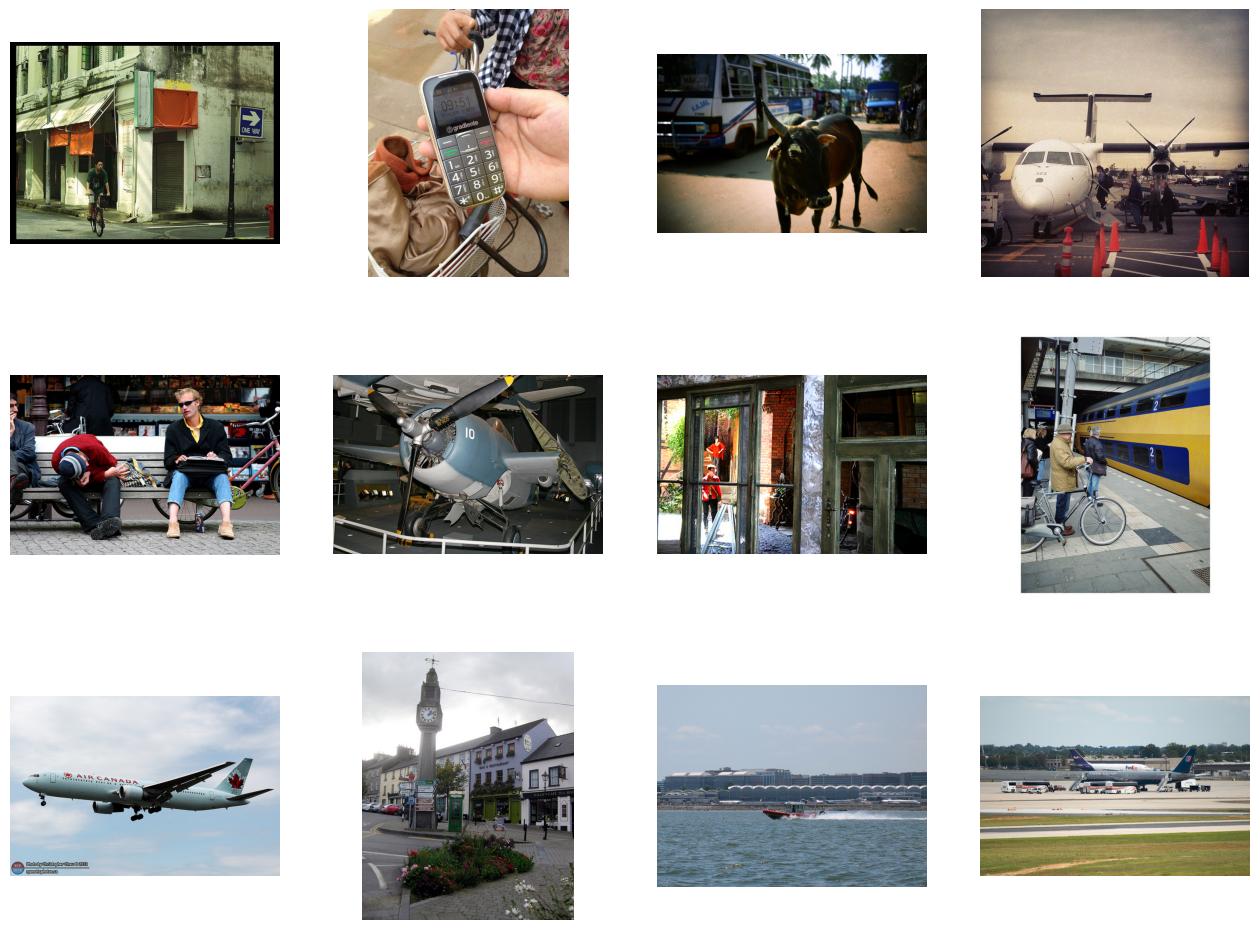

In [9]:
#Cargamos algunas imagenes aleatorias

fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):

    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

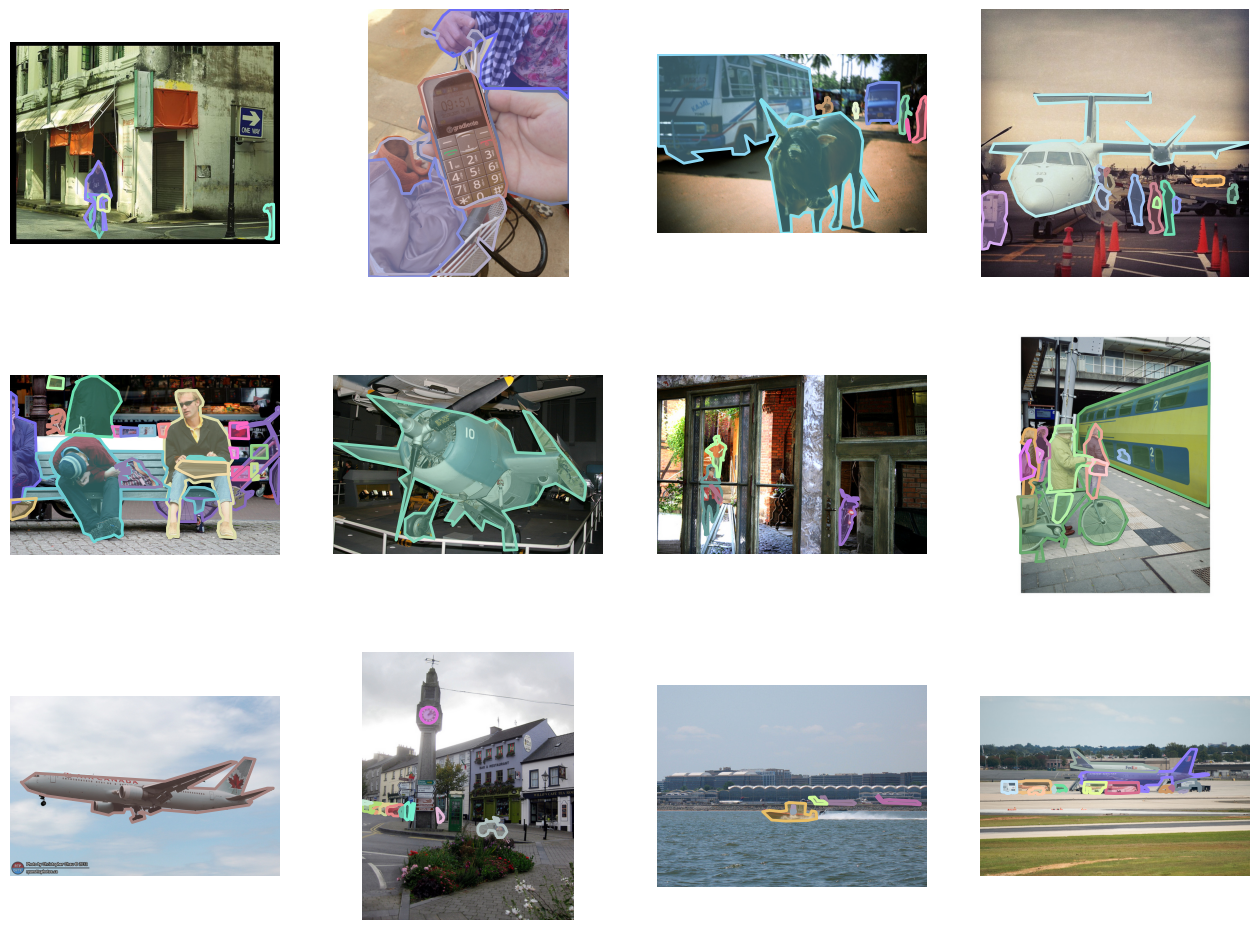

In [10]:
#Cargamos esas imagenes con objetos segmentados en ellas

fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):

    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    # print(anns)
    coco.showAnns(anns)


plt.show()

In [11]:
# Cargamos las imagenes con keypoints en ellas

# URL del archivo JSON de COCO (dentro de un archivo ZIP)
url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

# Descarga el archivo ZIP
response = requests.get(url)
response.raise_for_status()  # Asegúrate de que la solicitud fue exitosa

# Extrae el archivo JSON del ZIP en memoria
with ZipFile(BytesIO(response.content)) as the_zip:
    with the_zip.open('annotations/person_keypoints_train2017.json') as file:
        coco_data = json.load(file)
        
# Inicializa y carga los datos en el objeto COCO
coco_kps = COCO()
coco_kps.dataset = coco_data
coco_kps.createIndex()

creating index...
index created!


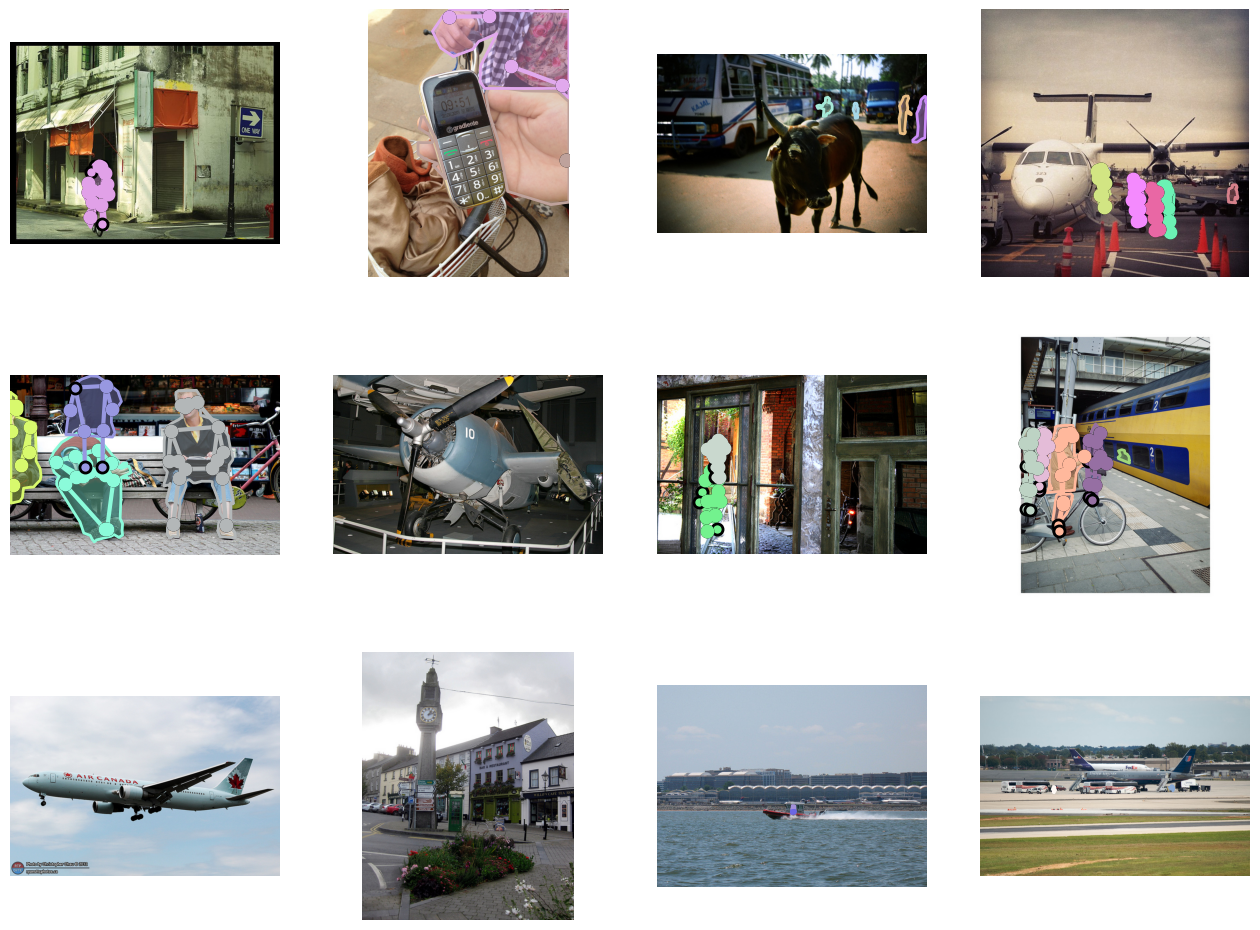

In [12]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco_kps.loadAnns(annIds)
    coco_kps.showAnns(anns)
    

plt.show()

In [13]:
# Cargamos las imágenes con sus correspondientes subtítulos
# URL del archivo ZIP que contiene los archivos JSON de COCO
zip_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

# Descarga el archivo ZIP
response = requests.get(zip_url)
response.raise_for_status()  # Asegúrate de que la solicitud fue exitosa

# Extrae el archivo JSON 'captions_train2017.json' del ZIP en memoria
with ZipFile(BytesIO(response.content)) as the_zip:
    with the_zip.open('annotations/captions_train2017.json') as file:
        coco_data = json.load(file)

# Inicializa y carga los datos en el objeto COCO
coco_caps = COCO()
coco_caps.dataset = coco_data
coco_caps.createIndex()

creating index...
index created!


A person on a bike on a city street.
A young person on a bicycle riding past a alleyway. 
A man rides his bike on a deserted street.
A boy riding a bicycle down a street past a one way sign.
A boy who is riding his bike down the street.


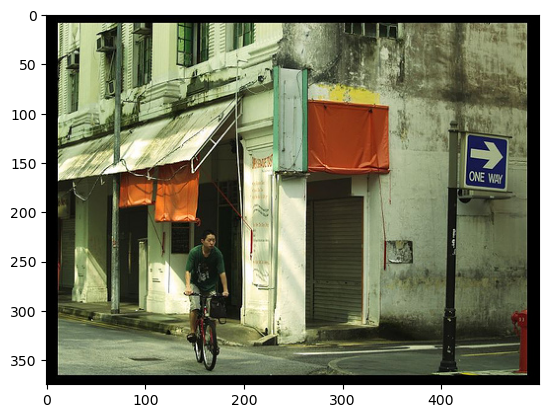

In [14]:
img = coco.loadImgs(next_pix[0])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

A person that is holding a cellphone over a basket.
a person holding a cell phone with big numbers
A person holds a mobile device on a city street.
A hand holding a cell phone displaying the time
New cell phone with large numbers displayed to see


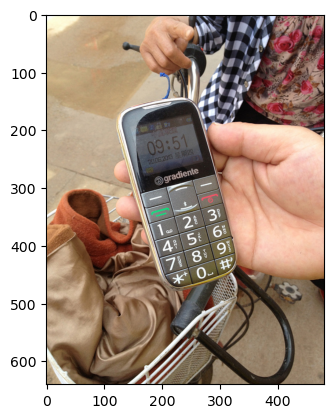

In [15]:
img = coco.loadImgs(next_pix[1])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

A couple of airplanes that are sitting on a runway.
Some very big commercial planes parked together in a lot.
a very large airplane that is on a runway
Airplanes parked on the runway with buses and trucks.
A large jet sitting on top of an airport runway.


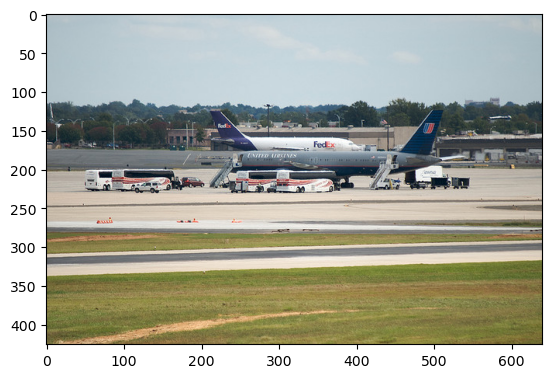

In [16]:
img = coco.loadImgs(next_pix[11])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

In [17]:
#Solo hemos cogido solo imagenes con objetos que incluyan "Bicycle" y "Airplane"
print("Imágenes totales para el entrenamiento: ", len(imgIdss))

Imágenes totales para el entrenamiento:  6221


PREPARANDO EL DATASET

In [18]:
#Agrupamos todos subtítulos que tenga una misma imagen y la guardamos

dataset = dict()
imgcaptions = []

for imgid in imgIdss:
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    for cap in anns:
        
        # Remove punctuation
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        
        # Replace - to blank
        cap = cap.replace("-"," ")
        
        # Split string into word list and Convert each word into lower case
        cap = cap.split()
        cap = [word.lower() for word in cap]
        
        # join word list into sentence and <start> and <end> tag to each sentence which helps 
        # LSTM encoder-decoder model while training.
        
        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)
        
    dataset[img['coco_url']] = imgcaptions 
    
    
print("Length of Dataset: ",len(dataset))
print(dataset['http://images.cocodataset.org/train2017/000000047084.jpg'])

Length of Dataset:  6221
['<start> a jumbo jet plane connected to a boarding deck <end>', '<start> a large blue passenger plane sits on the tarmac at the airport <end>', '<start> a blue commercial airplane parked at a jet way <end>', '<start> a large airplane that is sitting out on the runway <end>', '<start> a blue plane at the airport being offloaded <end>']


PREPROCESADO Y TOKENIZACIÓN DE LOS SUBTÍTULOS

In [19]:
from itertools import chain
flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]

tokenizer = Tokenizer(oov_token='<oov>') # Para esas palabras que no se encuentran en word_index
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1

print("Vocabulary length: ", total_words)
print("Bicycle ID: ", tokenizer.word_index['bicycle'])
print("Airplane ID: ", tokenizer.word_index['airplane'])

Vocabulary length:  6410
Bicycle ID:  28
Airplane ID:  13


In [ ]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix
#!jupyter nbextension install --py widgetsnbextension --sys-prefix
#!pip install jupyterlab_widgets
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!pip install --upgrade jupyter
#!pip install --upgrade jupyterlab

In [23]:

import ipywidgets as widgets
widgets.IntSlider()


from tensorflow.keras.applications import Xception
from tqdm.notebook import tqdm

model = Xception(include_top=False, pooling='avg')

image_features = {}

for img in tqdm(dataset.keys()):
    image = io.imread(img)
    if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    # Reescalamos tamaños de imgs a 299 x 299
    image = cv2.resize(image,(299,299))
    image = np.expand_dims(image, axis=0)
    
    # Normalizamos los píxeles de las imágenes
    image = image/127.5
    image = image - 1.0

    # Extraer las identidades de cada imagen
    feature = model.predict(image)
    image_features[img] = feature
    
print("Image features length: ", len(image_features))

  0%|          | 0/6221 [00:00<?, ?it/s]

1/1 [==============================] - 0s 115ms/step
Image features length:  6221


In [24]:
image_features['http://images.cocodataset.org/train2017/000000047084.jpg'].shape

(1, 2048)

In [25]:
#Aquí se haya el max_length entre los subtítulos. Ayudará a acotar cada subtítulo a una longitud similar

def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(dataset)
max_length

46

CREANDO UN GENERADOR DE DATOS

In [26]:
#crear una secuencia par input-output desde la descripción de imágenes.

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # Recorrer cada descripción de imagen
    for desc in desc_list:
        
        # codificar la secuencia
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # dividir una secuencia pares multiples X,y
        for i in range(1, len(seq)):
            
            # dividir into pares input y output
            in_seq, out_seq = seq[:i], seq[i]
            
            # secuencia de entrada
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # codificar secuencia de salida
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            
            
            X1.append(feature) # características de imagen
            X2.append(in_seq)  # secuencia input
            y.append(out_seq)  # secuencia output
            
    return np.array(X1), np.array(X2), np.array(y)

DEFINIR MODELO CNN-LSTM

In [27]:
# define el modelo de subtítulos
def define_model(total_words, max_length):

    # se reducen las características del modelo de 2048 a 256 nodos
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # modelo LSTM
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Fusión de ambos modelos
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # modelo resumido
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [31]:
#entrenamos el modelo
from keras.utils import plot_model

print('Dataset: ', len(dataset))
print('Descriptions: train=', len(dataset))
print('Photos: train=', len(image_features))
print('Vocabulary Size:', total_words)
print('Description Length: ', max_length)

model = define_model(total_words, max_length)
epochs=1
steps = len(dataset)

# making a directory models to save our models
import os
os.mkdir("models")

for i in range(epochs):
    generator = data_generator(dataset, image_features, tokenizer, max_length)
    model.fit(generator, epochs=10, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  6221
Descriptions: train= 6221
Photos: train= 6221
Vocabulary Size: 6410
Description Length:  46
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 46)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 46, 256)      1640960     ['input_11[0][0]']               
                                                                                                  
 dropout_6 (Dropout)            (None, 2048)         0           ['input_10[0][0]'] 

1/1 [==============================] - 1s 714ms/step



start a plane flying in the sky over a city skyline end


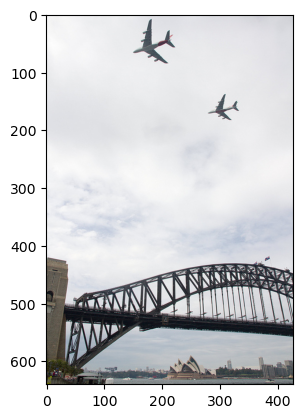

In [51]:
from PIL import Image

img_paths = ["data\\input\\imagenes_prueba\\000000001761.jpg",
            "data\\input\\imagenes_prueba\\000000022396.jpg",
            "data\\input\\imagenes_prueba\\000000087742.jpg",
            "data\\input\\imagenes_prueba\\000000098520.jpg",
            "data\\input\\imagenes_prueba\\000000100428.jpg",
            "data\\input\\imagenes_prueba\\000000101762.jpg",
            "data\\output\\divide_images\\panel_0.jpg"]

def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except Exception as e:
        print("ERROR: Couldn't open image! Make sure the image path and extension is correct. Details:", e)
        return None

    image = image.resize((299, 299))
    image = np.array(image)
    
    # for images that have 4 channels, we convert them into 3 channels
    if image.shape[2] == 4: 
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text

#max_length = 46

model = load_model('./models/model_0.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_paths[0], xception_model)
if photo is not None:
    img = Image.open(img_paths[0])
    description = generate_desc(model, tokenizer, photo, max_length)
    print("\n\n")
    print(description)
    plt.imshow(img)
    plt.show()
else:
    print("Image feature extraction failed.")

1/1 [==============================] - 0s 105ms/step



start a plane flying in the sky with smoke coming from it end


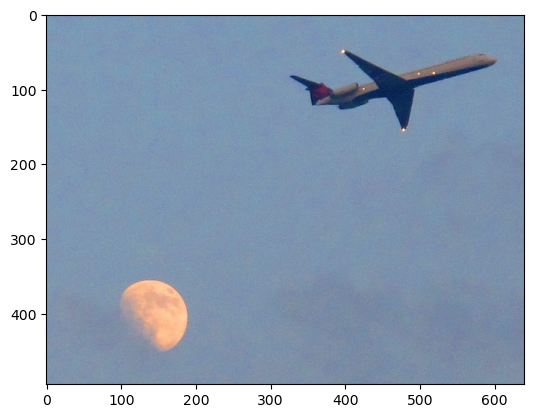

In [41]:
photo = extract_features(img_paths[1], xception_model)
img = Image.open(img_paths[1])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 108ms/step



start a cat is standing on a table with tons of stuff end


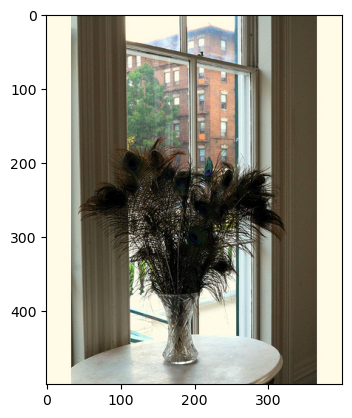

In [43]:
photo = extract_features(img_paths[2], xception_model)
img = Image.open(img_paths[2])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 113ms/step



start a large white airplane sitting on top of an airport tarmac end


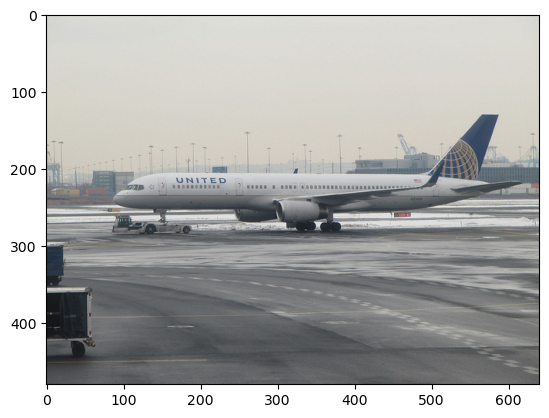

In [44]:
photo = extract_features(img_paths[3], xception_model)
img = Image.open(img_paths[3])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 173ms/step



start a man riding a bike down a street next to a flower center end


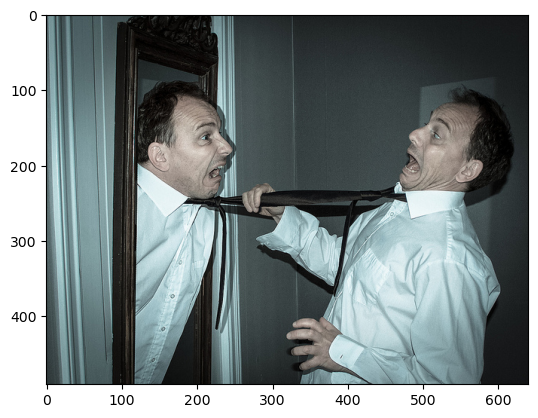

In [45]:
photo = extract_features(img_paths[4], xception_model)
img = Image.open(img_paths[4])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 102ms/step



start a bicycle parked in front of a building end


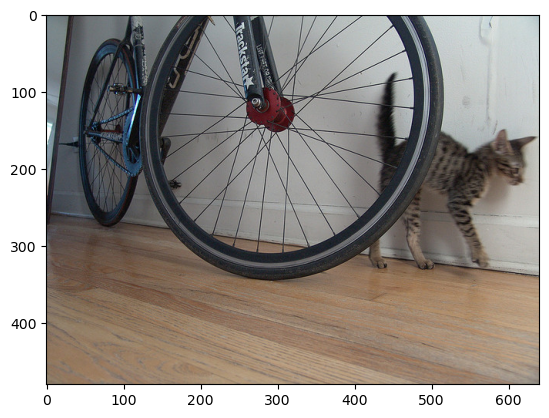

In [50]:
photo = extract_features(img_paths[5], xception_model)
img = Image.open(img_paths[5])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 106ms/step



start a man riding a bike down a street next to a building end


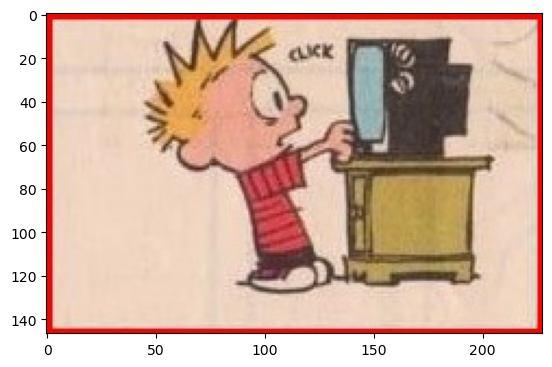

In [52]:
photo = extract_features(img_paths[6], xception_model)
img = Image.open(img_paths[6])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [53]:
#ESTO HAY QUE PONERLO AL FINAL DEL TODO, SI NO BORRA LA ASIGNACIÓN DE VARIABLES !!!!!!
# Liberar memoria explícitamente

del coco_data
del coco
del coco_kps  # Elimina la referencia al objeto de datos cargado
del coco_caps  # Elimina la referencia al objeto COCO

# Llama al recolector de basura para liberar memoria no utilizada
gc.collect()

458841